In [1]:
!pip install -q pyyaml h5py

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16032925936186826713
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15303506037300758049
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15928269210
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1469049133132322521
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15176277818607365012
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
batch_size = 128
epoch = 8
NUM_CLASSES = 1066

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        zoom_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../data/train',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../data/validation',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')


Found 630277 images belonging to 1066 classes.
Found 88887 images belonging to 1066 classes.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import numpy as np

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# for layer in resnet.layers[-5:]:
#     layer.trainable = False
    
out = Flatten()(resnet.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model2 = Model(resnet.input, out)
model2.summary()

/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 64, 64, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [9]:
checkpointer = ModelCheckpoint(filepath='../saved_model/weights_resnet50v2.h5', 
                               verbose=1, save_best_only=True)

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule, verbose=1)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)


In [12]:
opt = Adam(0.0001)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['categorical_accuracy'])
history = model2.fit_generator(generator=train_generator,
                     steps_per_epoch=630277//128,
                     validation_data=validation_generator,
                     validation_steps=88887//128,
                     epochs=epoch,
                     use_multiprocessing=True,
                     callbacks=[checkpointer, lr_sched],
                     workers=8,
                     verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/8
4923/4924 [============================>.] - ETA: 0s - loss: 1.4089 - categorical_accuracy: 0.7083
Epoch 00001: val_loss improved from inf to 0.51198, saving model to ../saved_model/weights_resnet50v2.h5
4924/4924 [==============================] - 1469s 298ms/step - loss: 1.4087 - categorical_accuracy: 0.7084 - val_loss: 0.5120 - val_categorical_accuracy: 0.8767

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/8
4923/4924 [============================>.] - ETA: 0s - loss: 0.5458 - categorical_accuracy: 0.8657
Epoch 00002: val_loss improved from 0.51198 to 0.40325, saving model to ../saved_model/weights_resnet50v2.h5
4924/4924 [==============================] - 1436s 292ms/step - loss: 0.5458 - categorical_accuracy: 0.8657 - val_loss: 0.4032 - val_categorical_accuracy: 0.9010

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/8
4923/4924

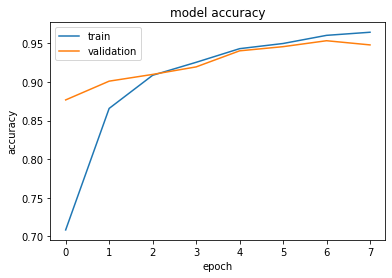

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

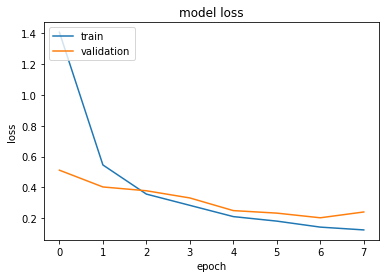

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
import pandas as pd
history_pd = pd.DataFrame.from_dict(history.history)
history_pd

,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr
0,1.406205,0.708356,0.511980,0.876700,0.000100
1,0.545868,0.865686,0.403246,0.900993,0.000100
2,0.356926,0.908601,0.378570,0.909717,0.000075
3,0.283988,0.925397,0.331974,0.919455,0.000075
4,0.211033,0.943058,0.249949,0.940258,0.000056
5,0.181767,0.949764,0.233621,0.945661,0.000056
6,0.142855,0.960316,0.203347,0.953350,0.000042
7,0.124716,0.964335,0.241048,0.947935,0.000042
